In [151]:
import pandas as pd
import re
import csv
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [142]:
path = 'C:/Laptop/NewQ/Sprint 10/Persona/DL/'
data_file_name = path+'data.csv'
abbr_file_name = path+'abbreviation.csv'
word_count_file = path +'word_count.csv'

In [215]:
abbr = pd.read_csv(abbr_file_name).set_index('word').to_dict()
abbr = abbr['Abbreviation']

less_freq_words = []

def replaceAbbr(txt):
    words = txt.split(' ')
    for index, word in enumerate(words):
        if word in abbr:
            words[index] = abbr[word]
    return ' '.join(words)

def remove_less_freq_words(txt):
    words = txt.split(' ')
    for index, word in enumerate(words):
        if word in less_freq_words:
            words[index] = ''
    return ' '.join(words)



In [110]:
replaceAbbr('qa')

'quality assurance'

In [189]:
data = pd.read_csv(data_file_name, encoding='utf-8')
print(data.shape)
print(data.columns.values)


(94400, 2)
['Title' 'Persona']


In [220]:
processed_data = data.copy()

# replacing '-'' with spaces
processed_data['Title'] = processed_data['Title'].apply(lambda x: re.sub('[-]', ' ', x))
processed_data['Title'] = processed_data['Title'].apply(lambda x: re.sub('[ ]+', ' ', x))


processed_data['Title'] = processed_data['Title'].apply(lambda x: x.replace('.net', 'dotnet'))

# replacing non alphabets
processed_data['Title'] = processed_data['Title'].apply(lambda x: re.sub('[^a-zA-Z ]', '', x))

# converting to lower case
processed_data['Title'] = processed_data['Title'].apply(lambda x: x.lower().strip())

# expand abbreviations
processed_data['Title'] = processed_data['Title'].apply(replaceAbbr)

processed_data['Title'] = processed_data['Title'].apply(lambda x: re.sub('[ ]+', ' ', x))


In [226]:
titles = processed_data['Title']

In [227]:
# number of characters in each title
title_length = [len(title) for title in titles]
print('Min Characters: '+str(min(title_length)))
print('Max Characters: '+str(max(title_length)))


Min Characters: 0
Max Characters: 151


Min Words: 1
Max Words: 19


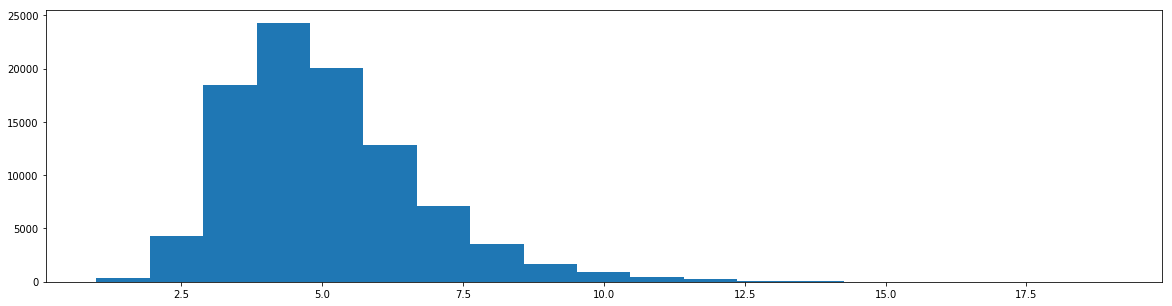

In [232]:
# number of words in each title
title_word_length = [len(title.split(' ')) for title in titles]
print('Min Words: '+str(min(title_word_length)))
print('Max Words: '+str(max(title_word_length)))
plt.figure(figsize = (20,5))
plt.hist(title_word_length, bins=19)

plt.show()

In [194]:
titles[1]

'associate financial risk'

In [233]:
for ix, length in enumerate(title_word_length):
    if length ==19:
        print(titles[ix])

senior manager information technology risk management department systems planning office systems division the bank of tokyo mitsubishi ufj ltd


In [223]:
words = []
temp = [words.extend(title.split(' ')) for title in titles]
word_count = {}
for word in words:
    if word in word_count:
        word_count[word] = word_count[word]+1
    else:
        word_count[word] = 1

In [219]:
with open(word_count_file, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['word','count'])
    for k, v in word_count.items():
        writer.writerow([k,v])

In [224]:
less_freq_words = []
for k, v in word_count.items():
    if v <5:
        less_freq_words.append(k)

In [225]:
processed_data['Title'] = processed_data['Title'].apply(remove_less_freq_words)


In [244]:
second_processed_data = processed_data.copy()
second_processed_data = second_processed_data[second_processed_data['Title'].map(len)>2]
second_processed_data = second_processed_data[second_processed_data['Title'].map(lambda x: len(x.split(' ')))>1]

In [245]:
second_processed_data.shape

(94025, 2)

In [354]:
top_words = 5000
(X_ttrain, y_ttrain), (X_ttest, y_ttest) = imdb.load_data(num_words=top_words)

In [258]:
words = []
temp = [words.extend(title.split(' ')) for title in second_processed_data['Title']]
word_to_int = {word:idx for idx, word in enumerate(set(words))}
int_to_word = {idx:word for idx, word in enumerate(set(words))}

In [264]:
persona_to_int = {persona:idx for idx, persona in enumerate(set(second_processed_data['Persona']))}
int_to_persona = {idx:persona for idx, persona in enumerate(set(second_processed_data['Persona']))}

In [279]:
def convert_data(txt):
    words = txt.split(' ')
    converted = [word_to_int[word] for word in words]
    return converted

In [342]:
from keras.utils import to_categorical
second_processed_data.reset_index(drop=True, inplace=True)
X = second_processed_data['Title'].apply(convert_data)
Y = to_categorical(second_processed_data['Persona'].apply(lambda x: persona_to_int[x]))

In [335]:
test_train_split = 0.7
max_title_length = 15
embedding_vecor_length = 32
num_words = len(word_to_int)

In [360]:
import random

selected = [1 if random.randint(1,100) < test_train_split*100 else 0 for idx in range(1,len(X))]
X_train = []
Y_train = []
X_test = []
Y_test = []

for idx, val in enumerate(selected):
    if val == 1:
        X_train.append(list(X[idx]))
        Y_train.append(list(Y[idx]))
    else:
        X_test.append(list(X[idx]))
        Y_test.append(list(Y[idx]))

In [361]:
print(len(X_train))
print(len(Y_train))
print(len(X_test))
print(len(Y_test))
num_words

65003
65003
29021
29021


2202

In [364]:
print(X_train[1])
print(type(X_ttrain[1]))

[  0   0   0   0   0   0   0   0   0   0   0   0 559 699 732]
<class 'list'>


In [338]:
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

In [362]:
X_train = sequence.pad_sequences(X_train, maxlen=max_title_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_title_length)

In [397]:
model = Sequential()
model.add(Embedding(num_words, embedding_vecor_length, input_length=max_title_length))

model.add(LSTM(100))

model.add(Dense(25, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())
model.fit(X_train, Y_train, epochs=5, batch_size=64)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 15, 32)            70464     
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_9 (Dense)              (None, 25)                2525      
Total params: 126,189
Trainable params: 126,189
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
65003/65003 [==============================] - 41s - loss: 1.0596 - acc: 0.7152    
Epoch 2/5
65003/65003 [==============================] - 43s - loss: 0.4251 - acc: 0.8745    
Epoch 3/5
65003/65003 [==============================] - 42s - loss: 0.3310 - acc: 0.8940    
Epoch 4/5
65003/65003 [==============================] - 42s - loss: 0.2876 - acc: 0.9035    
Epoch 5/5
65003/650

In [407]:
# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test Accuracy: %.2f%%" % (scores[1]*100))

Test Accuracy: 89.30%


In [445]:
test_str = pd.Series(['administrative assistant to vice president operations', 
                        'executive assistant john',
                        'assistant vice president operations',
                        'vice president cybersecurity',
                        'senior architect',
                        'project manager',
                        'senior software engineer',
                        'application developer',
                        'lead software engineer'
                    ])

test_int = test_str.apply(lambda x:[word_to_int[word] for word in x.split(' ')])
#test_int = [[word_to_int[word] for word in test_str.split(' ')]]


tt = sequence.pad_sequences(test_int, maxlen=max_title_length)
prediction = model.predict(tt)
output = [int_to_persona[val] for val in np.argmax(prediction, axis =1)]
z = [print(persona) for persona in output]


Admin
Admin
Grant - VP of IT Operations
VP OF SECURITY
BRIAN - ENTERPRISE ARCHITECT
Kathy - Business Transformation
INDIVIDUAL CONTRIBUTOR OPERATIONS
Individual Contributor Apps
DAN - LEAD DEVELOPER


In [384]:
print(int_to_word[650])
print(int_to_word[844])
print(int_to_word[1931])


support
specialist
exec
